<a href="https://colab.research.google.com/gist/tyty9798123/eb2cb615b2b66573d38bb9f116621c66/experiment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
import numpy as np
import pandas as pd
import os

import time
import datetime
import glob

import warnings
warnings.filterwarnings("ignore")

from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 300
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import ClusterCentroids
from sklearn.ensemble import BaggingClassifier

import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Data Preprocessing

## Change Time Zone

In [ ]:
!date -R
os.environ["TZ"] = "America/New_York"
time.tzset()
!date -R

Mon, 02 Jan 2023 14:02:39 +0000
Mon, 02 Jan 2023 09:02:40 -0500


## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = './drive/MyDrive/stocktwits_dataset'
symbol = 'SPY'
my_dir = os.path.join(dir, symbol)

In [ ]:
saved_path = os.path.join(my_dir, symbol+'_concat_files.csv') #Load Stocktwits Sentiment Dataset
df = pd.read_csv(saved_path)

In [ ]:
df.head()

Sentence      Timestamp  \
0                $SPY every time I see a bearish tag  1577837135000   
1  $SPY not even Trump can save the coming correc...  1577837452000   
2  $SPY Happy New Years guys; S&amp;P 500 returne...  1577837787000   
3    $SPY I kinda don&#39;t want to let 2019 go... 😳  1577837846000   
4                                    $SPY Hi guys 👋🏻  1577837968000   

              DateTime Sentiment  
0  2019/12/31 19:05:35   Bullish  
1  2019/12/31 19:10:52   Bearish  
2  2019/12/31 19:16:27   Bullish  
3  2019/12/31 19:17:26   Bullish  
4  2019/12/31 19:19:28   Bullish

## Load Historical Stock Data

In [ ]:
fin_dir = os.path.join('./drive/MyDrive/stocktwits_dataset', 'Financial', symbol+'.csv')
fin_df = pd.read_csv(fin_dir)
fin_df.head()

Date      Open      High       Low     Close      VWAP    Volume  \
0  2022-05-31  411.7713  414.6688  408.2665  411.1540  411.4038  95718004   
1  2022-05-27  406.1556  413.5935  405.9465  413.4740  410.7660  84653856   
2  2022-05-26  396.9553  405.2893  396.7363  403.5668  402.7934  81933455   
3  2022-05-25  390.6227  397.7320  390.2045  395.6609  394.1357  91225026   
4  2022-05-24  390.8716  393.4505  385.2957  392.1959  389.3216  91251910   

   Change Percent  Change  Trade Value  
0          -0.561 -2.3200  39554271900  
1           2.455  9.9072  34898718400  
2           1.998  7.9059  33104555200  
3           0.883  3.4650  36106475400  
4          -0.763 -3.0170  35712086900

## Load Historcial Stock Price (Intraday)

In [ ]:
# intraday stock price (15 mins update)
path_15mins = './drive/MyDrive/stocktwits_dataset/fifteen_mins/' + symbol
all_files = glob.glob(
    os.path.join(path_15mins, '*.csv')
)
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

fifteen_mins_df = pd.concat(li, axis=0, ignore_index=True)
fifteen_mins_df = fifteen_mins_df.drop_duplicates(subset=['time'])
# Divide DateTime
Dates = []
Times = []
for index, row in fifteen_mins_df.iterrows():
  Dates.append(
      row["time"].split(" ")[0]
  )
  Times.append(
      row["time"].split(" ")[1]
  )
fifteen_mins_df["Date"] = Dates
fifteen_mins_df["Time"] = Times
fifteen_mins_df = fifteen_mins_df.drop(columns=['time'])
fifteen_mins_df.head()

open    high     low   close  volume        Date      Time
0  444.0500  444.06  443.67  443.70   40553  2022-03-21  20:00:00
1  444.2500  444.25  444.00  444.08   25414  2022-03-21  19:45:00
2  444.1100  444.25  444.08  444.25   13807  2022-03-21  19:30:00
3  444.3100  444.34  444.10  444.10   47152  2022-03-21  19:15:00
4  444.4799  444.49  444.30  444.33    6928  2022-03-21  19:00:00

## Add Column Open Timestamp

In [ ]:
# Open Timestamp is the timestamp at open(9:30 AM)
Open_Timestamp = []
for i in range(len(fin_df)):
    temp = time.mktime(datetime.datetime.strptime(fin_df["Date"][i], "%Y-%m-%d").timetuple()) + (9.5*60*60)
    Open_Timestamp.append(int(temp))
fin_df["Open Timestamp"] = Open_Timestamp
fin_df.head()

Date      Open      High       Low     Close      VWAP    Volume  \
0  2022-05-31  411.7713  414.6688  408.2665  411.1540  411.4038  95718004   
1  2022-05-27  406.1556  413.5935  405.9465  413.4740  410.7660  84653856   
2  2022-05-26  396.9553  405.2893  396.7363  403.5668  402.7934  81933455   
3  2022-05-25  390.6227  397.7320  390.2045  395.6609  394.1357  91225026   
4  2022-05-24  390.8716  393.4505  385.2957  392.1959  389.3216  91251910   

   Change Percent  Change  Trade Value  Open Timestamp  
0          -0.561 -2.3200  39554271900      1654003800  
1           2.455  9.9072  34898718400      1653658200  
2           1.998  7.9059  33104555200      1653571800  
3           0.883  3.4650  36106475400      1653485400  
4          -0.763 -3.0170  35712086900      1653399000

## Keey Only Date, Open Timestamp, Change Percent

In [ ]:
fin_tmp_df = DataFrame()
fin_tmp_df["Date"] = fin_df["Date"]
fin_tmp_df["Open Timestamp"] = fin_df["Open Timestamp"]
fin_tmp_df["Change Percent"] = fin_df["Change Percent"]
fin_tmp_df.head()

Date  Open Timestamp  Change Percent
0  2022-05-31      1654003800          -0.561
1  2022-05-27      1653658200           2.455
2  2022-05-26      1653571800           1.998
3  2022-05-25      1653485400           0.883
4  2022-05-24      1653399000          -0.763

## Get Sentiment Index

In [ ]:
def get_sentiment_index_two_class(concated, timestamp, hour_1, hour_2): 
  open_timestamp = timestamp
  filter1 = concated['Timestamp'] < (open_timestamp - hour_1 *(60*60) ) * 1000
  filter2 = concated["Timestamp"] > (open_timestamp - hour_2 *(60*60) ) * 1000
  concated = concated.where(filter1 & filter2)
  tmp = concated.dropna(subset=["Timestamp"])
  t = tmp.where( tmp['Sentiment'] == 'Bullish' )
  t = t.dropna(subset=["Timestamp"])
  num_of_positive = t.count()["Sentiment"]
  num_of_negative = tmp.count()["Sentiment"] - t.count()["Sentiment"]
  return np.log( (1+num_of_positive) / (1+num_of_negative) )

## Get Previous Financial Data

In [ ]:
def getPrevFinancialData(Date):
  current_index = fin_df.where(fin_df["Date"] == Date).dropna(subset=["Date"]).index[0]
  prev_index = current_index + 1
  return fin_df.iloc[prev_index]

In [ ]:
def getPrevFinancialDataWithDay(Date, num_of_days):
  current_index = fin_df.where(fin_df["Date"] == Date).dropna(subset=["Date"]).index[0]
  prev_index = current_index + num_of_days
  return fin_df.iloc[prev_index]

## Function of Get Percentage Change

In [ ]:
def get_percentage_change_with_mins(date, time):
  tmp = fifteen_mins_df[(fifteen_mins_df.Date == date) & (fifteen_mins_df.Time == time)]
  tmp = tmp.dropna(subset=["Time"])
  tmp['open'] = tmp['open'].apply(lambda x: float(x))
  tmp['high'] = tmp['high'].apply(lambda x: float(x))
  tmp['low'] = tmp['low'].apply(lambda x: float(x))
  tmp['close'] = tmp['close'].apply(lambda x: float(x))

  return tmp

In [ ]:
float( get_percentage_change_with_mins('2022-02-15', "16:00:00")["close"] )

444.703427328

In [ ]:
def split(word):
    return [char for char in word]

In [ ]:
time = "1200"
num = 9
generated_file_name = f'processed_2020_with_{time}_{num}.csv'
print(generated_file_name)

processed_2020_with_1200_9.csv



## Generate the data Before training.

In [ ]:
dataset = DataFrame()
concat_path = saved_path
concated = pd.read_csv(concat_path)

#Features
positive_percent_pre_market = [] #04:00~9:30 0, 5.5
positive_percent_55_95 = [] #00:00~04:00
positive_percent_95_135 = [] #20:00~00:00
positive_percent_after_market = [] #16:00~20:00
positive_percent_55_135 = []
positive_percent_yesterday_market = []
positive_percent_the_day_before_yesterday = []
positive_sum_pre_market = []
negative_sum_pre_market = []

positive_sum_55_95 = []
negative_sum_55_95 = []

positive_sum_95_135 = []
negative_sum_95_135 = []

positive_sum_after_market = []
negative_sum_after_market = []

positive_sum_yesterday_market = []
negative_sum_yesterday_market = []

sentiment_number_24hr = []
dates = []

prev_open = []
prev_high = []
prev_low =[]
prev_close = []
prev_volume = []
prev_change_percent = []
prev_vwap = []
prev_trade_value = []
prev_hlpct = []
today_open = []
day_of_the_week = []
premarkets = []
percentage_change = []
for index, row in fin_tmp_df.iterrows():
  timestamp = row['Open Timestamp']# + 2 * 60 * 60
  print(row["Date"])
  print(index+1)
  try:

    open = float(get_percentage_change_with_mins(row["Date"], "09:30:00")['close'])
    close = float(get_percentage_change_with_mins(row["Date"], 
         f"{split(time)[0]}{split(time)[1]}:{split(time)[2]}{split(time)[3]}:00")['close'])
  except:
    print("error")
    break
  # 星期幾欄位
  
  temp = pd.Timestamp(row["Date"])
  day_of_the_week.append(int(temp.dayofweek+1))
  dates.append(
      row["Date"]
  )
  # Positive Percent
  positive_percent_pre_market.append(
      get_sentiment_index_two_class(concated, timestamp, 0, 5.5) #0~5.5為正常
  )
  positive_percent_55_95.append(
      get_sentiment_index_two_class(concated, timestamp, 5.5, 9.5)
  )

  positive_percent_95_135.append(
      get_sentiment_index_two_class(concated, timestamp, 9.5, 13.5)
  )
  positive_percent_55_135.append(
      get_sentiment_index_two_class(concated, timestamp, 5.5, 13.5)
  )
  
  positive_percent_after_market.append(
      get_sentiment_index_two_class(concated, timestamp, 13.5, 17.5)
  )
  positive_percent_yesterday_market.append(
      get_sentiment_index_two_class(concated, timestamp, 17.5, 24)
  )
  positive_percent_the_day_before_yesterday.append(
      get_sentiment_index_two_class(concated, timestamp, 24, 48)
  )
  """
  sentiment_number_24hr.append(
      getSentimentSum(concated, timestamp, 0, 24)[0] + getSentimentSum(concated, timestamp, 0, 24)[1]
  )"""

  # Previous Day Data
  prev_open.append(
      getPrevFinancialData(row["Date"])["Open"]
  )
  prev_high.append(
      getPrevFinancialData(row["Date"])["High"]
  )
  prev_low.append(
      getPrevFinancialData(row["Date"])["Low"]
  )
  prev_close.append(
      getPrevFinancialData(row["Date"])["Close"]
  )
  prev_hlpct.append(
      (getPrevFinancialData(row["Date"])["High"] - getPrevFinancialData(row["Date"])["Low"]) / getPrevFinancialData(row["Date"])["Low"]
  )
  prev_volume.append(
      getPrevFinancialData(row["Date"])["Volume"]
  )
  
  prev_change_percent.append(
      ( getPrevFinancialData(row["Date"])["Close"] - getPrevFinancialData(row["Date"])["Open"] ) / getPrevFinancialData(row["Date"])["Open"]
      #getPrevFinancialData(row["Date"])["Change Percent"]
  )
  prev_vwap.append(
      getPrevFinancialData(row["Date"])["VWAP"]
  )
  prev_trade_value.append(
      getPrevFinancialData(row["Date"])["Trade Value"]
  )
  # Label
  percentage_change.append(
      ( close - open ) / open
  )
  print("totally appended")
# Features
dataset["Date"] = dates
dataset["day_of_the_week"] = day_of_the_week
dataset["positive_percent_pre_market"] = positive_percent_pre_market
dataset["positive_percent_55_135"] = positive_percent_55_135
dataset["positive_percent_55_95"] = positive_percent_55_95
dataset["positive_percent_95_135"] = positive_percent_95_135
dataset["positive_percent_after_market"] = positive_percent_after_market
dataset["positive_percent_yesterday_market"] = positive_percent_yesterday_market
dataset['positive_percent_the_day_before_yesterday'] = positive_percent_the_day_before_yesterday

#dataset["sentiment_number_24hr"] = sentiment_number_24hr

dataset["Prev Open"] = prev_open
dataset["Prev Close"] = prev_close
dataset["Prev High"] = prev_high
dataset["Prev Low"] = prev_low
dataset["Prev HLPCT"] = prev_hlpct
dataset["Prev Volume"] = prev_volume
dataset["Prev Change Percent"] = prev_change_percent
dataset["Prev Trade Value"] = prev_trade_value
dataset["Prev VWAP"] = prev_vwap
#dataset["Premarket Changed"] = premarkets
# Label
dataset["percentage_change"] = percentage_change

# 刪除有0或是空的列
print(dataset)

processed_path = os.path.join('./drive/MyDrive/stocktwits_dataset', symbol, generated_file_name)
dataset.to_csv(processed_path)

2022-05-31
1
totally appended
2022-05-27
2
totally appended
2022-05-26
3
totally appended
2022-05-25
4
totally appended
2022-05-24
5
totally appended
2022-05-23
6
totally appended
2022-05-20
7
totally appended
2022-05-19
8
totally appended
2022-05-18
9
totally appended
2022-05-17
10
totally appended
2022-05-16
11
totally appended
2022-05-13
12
totally appended
2022-05-12
13
totally appended
2022-05-11
14
totally appended
2022-05-10
15
totally appended
2022-05-09
16
totally appended
2022-05-06
17
totally appended
2022-05-05
18
totally appended
2022-05-04
19
totally appended
2022-05-03
20
totally appended
2022-05-02
21
totally appended
2022-04-29
22
totally appended
2022-04-28
23
totally appended
2022-04-27
24
totally appended
2022-04-26
25
totally appended
2022-04-25
26
totally appended
2022-04-22
27
totally appended
2022-04-21
28
totally appended
2022-04-20
29
totally appended
2022-04-19
30
totally appended
2022-04-18
31
totally appended
2022-04-14
32
totally appended
2022-04-13
33
tot

In [ ]:
processed_path = os.path.join('./drive/MyDrive/stocktwits_dataset', symbol, generated_file_name)
print(processed_path)

dataset = pd.read_csv(processed_path)

# Dele
dataset = dataset.drop(
    [
     'Prev VWAP',#c
     'positive_percent_55_95',
     'positive_percent_55_135',
     'positive_percent_the_day_before_yesterday',
     'positive_percent_95_135',
     'Prev HLPCT',#c



    ],
    axis=1
)


dataset = dataset.drop(
    [
     'Unnamed: 0',
    ],
    axis=1
)
dataset["percentage_change"] = dataset["percentage_change"] * 100


days_of_week = pd.get_dummies(dataset.day_of_the_week)
dataset = pd.concat([dataset, days_of_week], axis=1)
temp_percentage_change = dataset["percentage_change"]
dataset = dataset.drop(["percentage_change"], axis=1)
dataset["percentage_change"] = temp_percentage_change
dataset = dataset.drop(['day_of_the_week'], axis=1)
dataset = dataset.drop(
    [
     1, 
     2, 
     3, 
     4, 
     5
    ],
    axis=1
)

end_index = dataset[dataset['Date']=='2022-02-28'].index[0]
start_testing_index = (len(dataset.index) - dataset[dataset['Date']=='2021-04-05'].index[0]) - 1
dataset = dataset[end_index:]
dataset = dataset.iloc[::-1]
print("End Index", end_index)
print("Start Testing Index", start_testing_index)
dataset

./drive/MyDrive/stocktwits_dataset/SPY/processed_2020_with_1200_9.csv
End Index 64
Start Testing Index 253


Date  positive_percent_pre_market  positive_percent_after_market  \
545  2020-04-01                    -1.422599                      -1.524813   
544  2020-04-02                    -0.910366                      -1.002712   
543  2020-04-03                    -0.599364                      -0.438722   
542  2020-04-06                    -0.145293                      -0.415603   
541  2020-04-07                     0.086509                      -0.455326   
..          ...                          ...                            ...   
68   2022-02-22                     0.168762                      -0.460577   
67   2022-02-23                    -0.090972                       0.145774   
66   2022-02-24                    -0.880139                      -0.765158   
65   2022-02-25                     0.081917                       0.212922   
64   2022-02-28                    -0.268593                      -0.522102   

     positive_percent_yesterday_market  Prev Open  Prev Close  Prev High  \
545                          -0.956431   252.0256    249.3076   254.7048   
544                          -1.171735   239.8576    238.0875   249.2197   
543                          -0.985773   237.1590    243.5815   244.4037   
542                          -0.205190   242.5465    240.0607   245.0227   
541                          -0.322586   249.3946    256.1847   258.2546   
..                                 ...        ...         ...        ...   
68                           -0.674954   434.1005    431.0234   435.4206   
67                           -0.460940   428.7006    426.3978   432.2840   
66                           -0.726402   429.4649    418.8340   430.0605   
65                           -0.020409   407.9847    425.1371   425.5937   
64                           -0.697724   426.4375    434.5174   434.6067   

     Prev Low  Prev Volume  Prev Change Percent  Prev Trade Value  \
545  247.8277    193290928            -0.010785       49731996200   
544  235.9112    188373330            -0.007380       46454886300   
543  236.5786    176669824             0.027081       43613280900   
542  237.1880    134538553            -0.010249       33050036600   
541  240.0412    186692564             0.027226       48044974900   
..        ...          ...                  ...               ...   
68   428.6311    132414754            -0.007088       57720378000   
67   422.7152    124054581            -0.005372       53384444100   
66   418.2385    131884132            -0.024754       56332708600   
65   407.6076    213444305             0.042042       89499945200   
64   424.7004    121686081             0.018947       52825992700   

     percentage_change  
545           0.322646  
544           2.281811  
543          -1.006222  
542           1.147776  
541          -1.000146  
..                 ...  
68           -0.159655  
67           -0.882972  
66            1.861133  
65            1.659722  
64            1.217691  

[482 rows x 12 columns]

# Traning

In [ ]:
dataset.drop(["Date"], inplace=True, axis=1)
X, y = np.hsplit( dataset.to_numpy(), [-1])
_y = np.array(y>=0, dtype=int)

## Rolling Window

In [ ]:
def movement_data(X, y, current, n):
  
    
  #X_train = X[:current]
  #y_train = y[:current]

  X_train = X[current-n:current]
  y_train = y[current-n:current]
  
  X_test = X[current]
  y_test = y[current]
  return (X_train, np.array([X_test]), y_train, np.array([y_test]))

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import RobustScaler

history = []
history_w = []
history_score = []
range__ = [i for i in range(232, start_testing_index+1) if i % 2 == 0]

best_score = 0
best_n = 0
print(range__)
pred_his = []
c = 1
g = 'scale'
for i in range__:
  n=i
  score = 0
  count = 0
  preds = []
  while(True):
    try:
      start_num = n + count
      print(start_num, n)
      
      X_train, X_test, y_train, y_test = movement_data(X, _y, start_num, n)
      X_train, y_train = SMOTE(random_state=0, k_neighbors=5, n_jobs=-1).fit_resample(X_train, y_train)
      #標準化
      #scaler = StandardScaler()
      scaler = RobustScaler()
      scaler.fit(X_train) 
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)

      #訓練      
      bagging_clf = SVC().fit(X_train, y_train)
      #計算分數 0 or 1
      pred = bagging_clf.predict(X_test)[0]
      preds.append(pred)
      real = y_test[0][0]

      count+=1
      #答對
      if pred == real:
        score+=1
      #print("Score:", score)
      history.append(
          score / count
      )
      print(score / count)
    except:
      print("some exception occur")
      break
  pred_his.append(preds)
  if (score/count) > best_score:
    best_score = score/count
    best_n = n
    best_c = c
    best_g = g
  history_w.append(n)
  history_score.append(score / count)
  print("N:", n)
  print("Current Accuracy:", score / count)
  print("Best N:", best_n)
  print("Best Score:", best_score)


串流輸出內容已截斷至最後 5000 行。
405 232
0.5402298850574713
406 232
0.5371428571428571
407 232
0.5397727272727273
408 232
0.5423728813559322
409 232
0.5449438202247191
410 232
0.5418994413407822
411 232
0.5444444444444444
412 232
0.5469613259668509
413 232
0.5439560439560439
414 232
0.546448087431694
415 232
0.5489130434782609
416 232
0.5513513513513514
417 232
0.5483870967741935
418 232
0.5508021390374331
419 232
0.5478723404255319
420 232
0.5502645502645502
421 232
0.5526315789473685
422 232
0.5549738219895288
423 232
0.5520833333333334
424 232
0.5544041450777202
425 232
0.5567010309278351
426 232
0.558974358974359
427 232
0.5612244897959183
428 232
0.5634517766497462
429 232
0.5656565656565656
430 232
0.5628140703517588
431 232
0.565
432 232
0.5621890547263682
433 232
0.5594059405940595
434 232
0.5615763546798029
435 232
0.5637254901960784
436 232
0.5658536585365853
437 232
0.5679611650485437
438 232
0.5700483091787439
439 232
0.5721153846153846
440 232
0.569377990430622
441 232
0.5666666666666

In [ ]:
pred_his =  np.array(pred_his)

f1_scores = []
for his in pred_his:
  labels = _y[start_testing_index:]
  preds = his[-(len(dataset)-start_testing_index):]
  #print( confusion_matrix(labels, preds) )
  #print( "Accuracy Score:", accuracy_score(labels, preds) )
  #print( "Precision。Score:", precision_score(labels, preds) )
  #print( "Recall Score:", recall_score(labels, preds) )
  print( "F1 Score:", f1_score(labels, preds) )
  f1_scores.append(f1_score(labels, preds))

F1 Score: 0.5714285714285714
F1 Score: 0.5872340425531916
F1 Score: 0.5847457627118644
F1 Score: 0.5775862068965517
F1 Score: 0.591304347826087
F1 Score: 0.5726872246696034
F1 Score: 0.591304347826087
F1 Score: 0.5974025974025973
F1 Score: 0.5847457627118644
F1 Score: 0.5575221238938053
F1 Score: 0.5964912280701755


In [ ]:
sum(f1_scores) / len(f1_scores)

0.5829502014536726

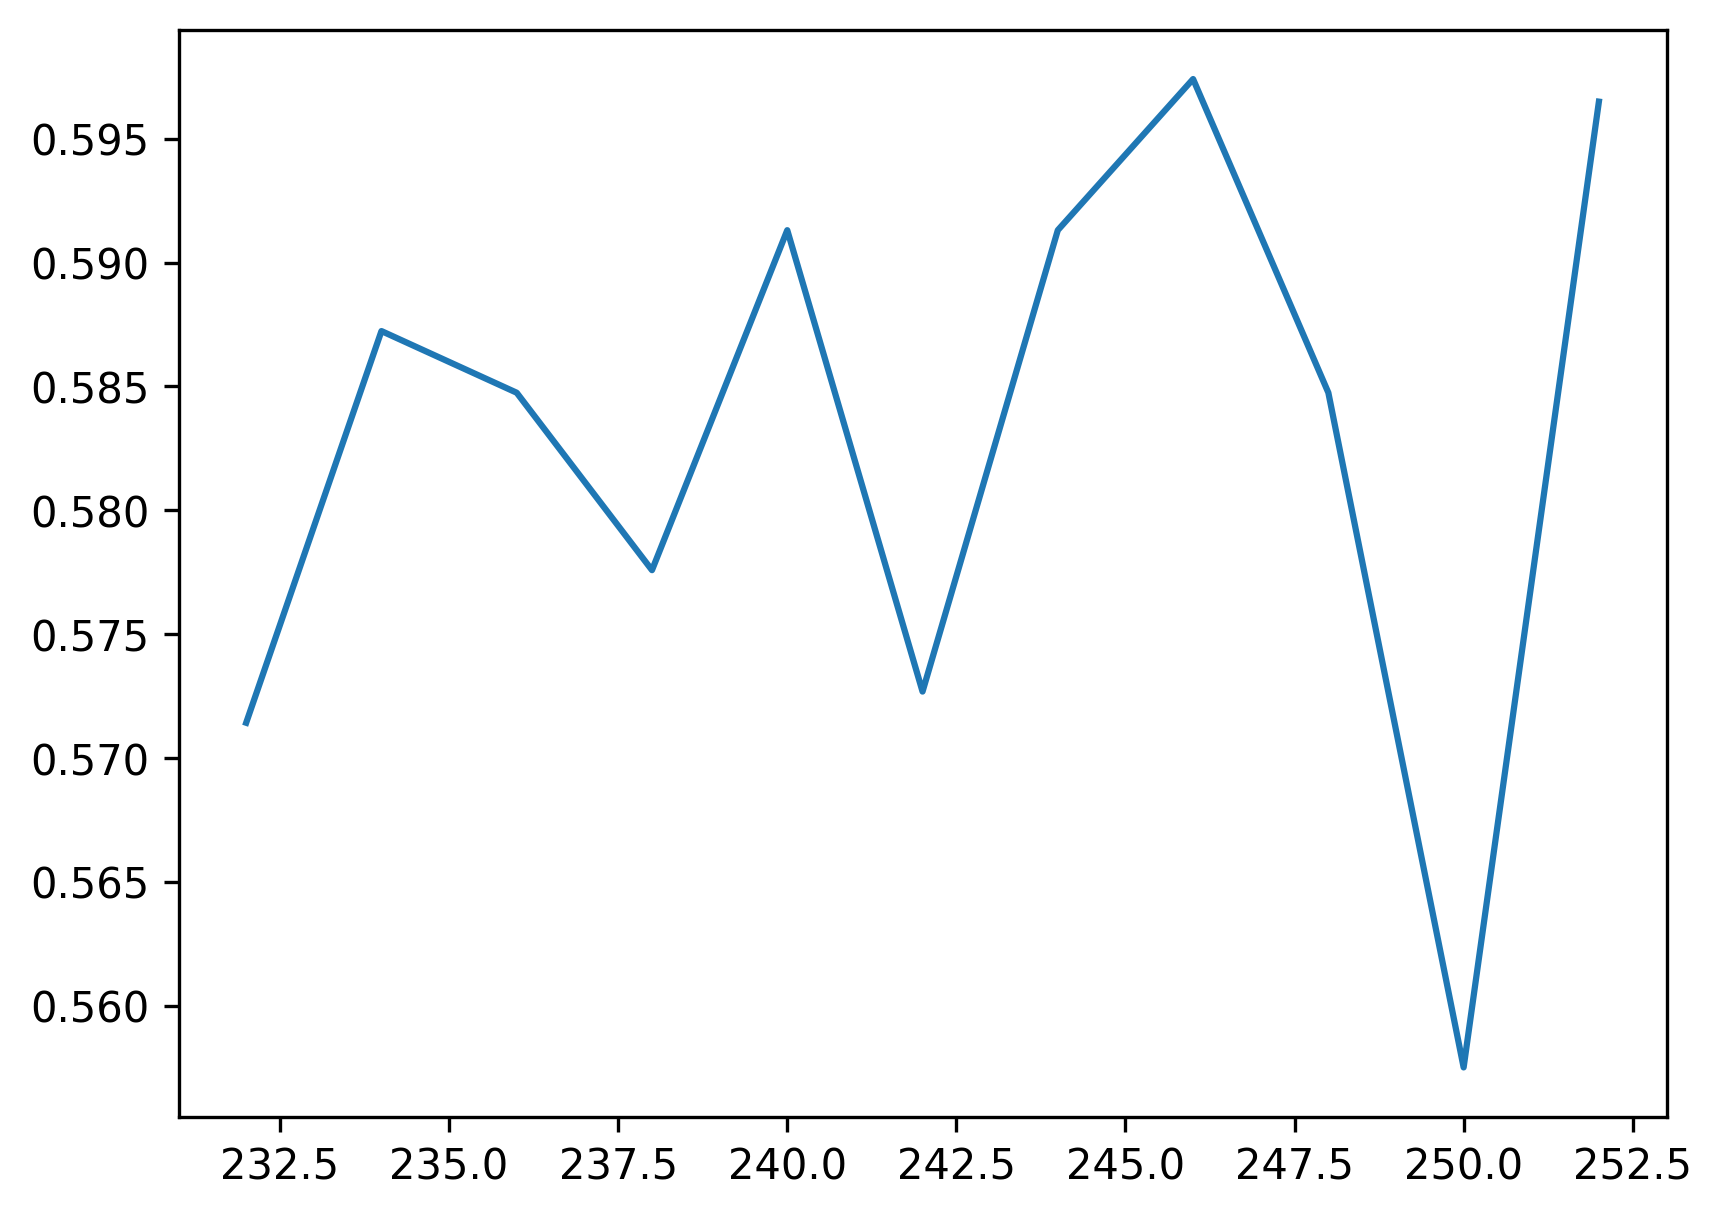

In [ ]:
plt.plot(range__, f1_scores)

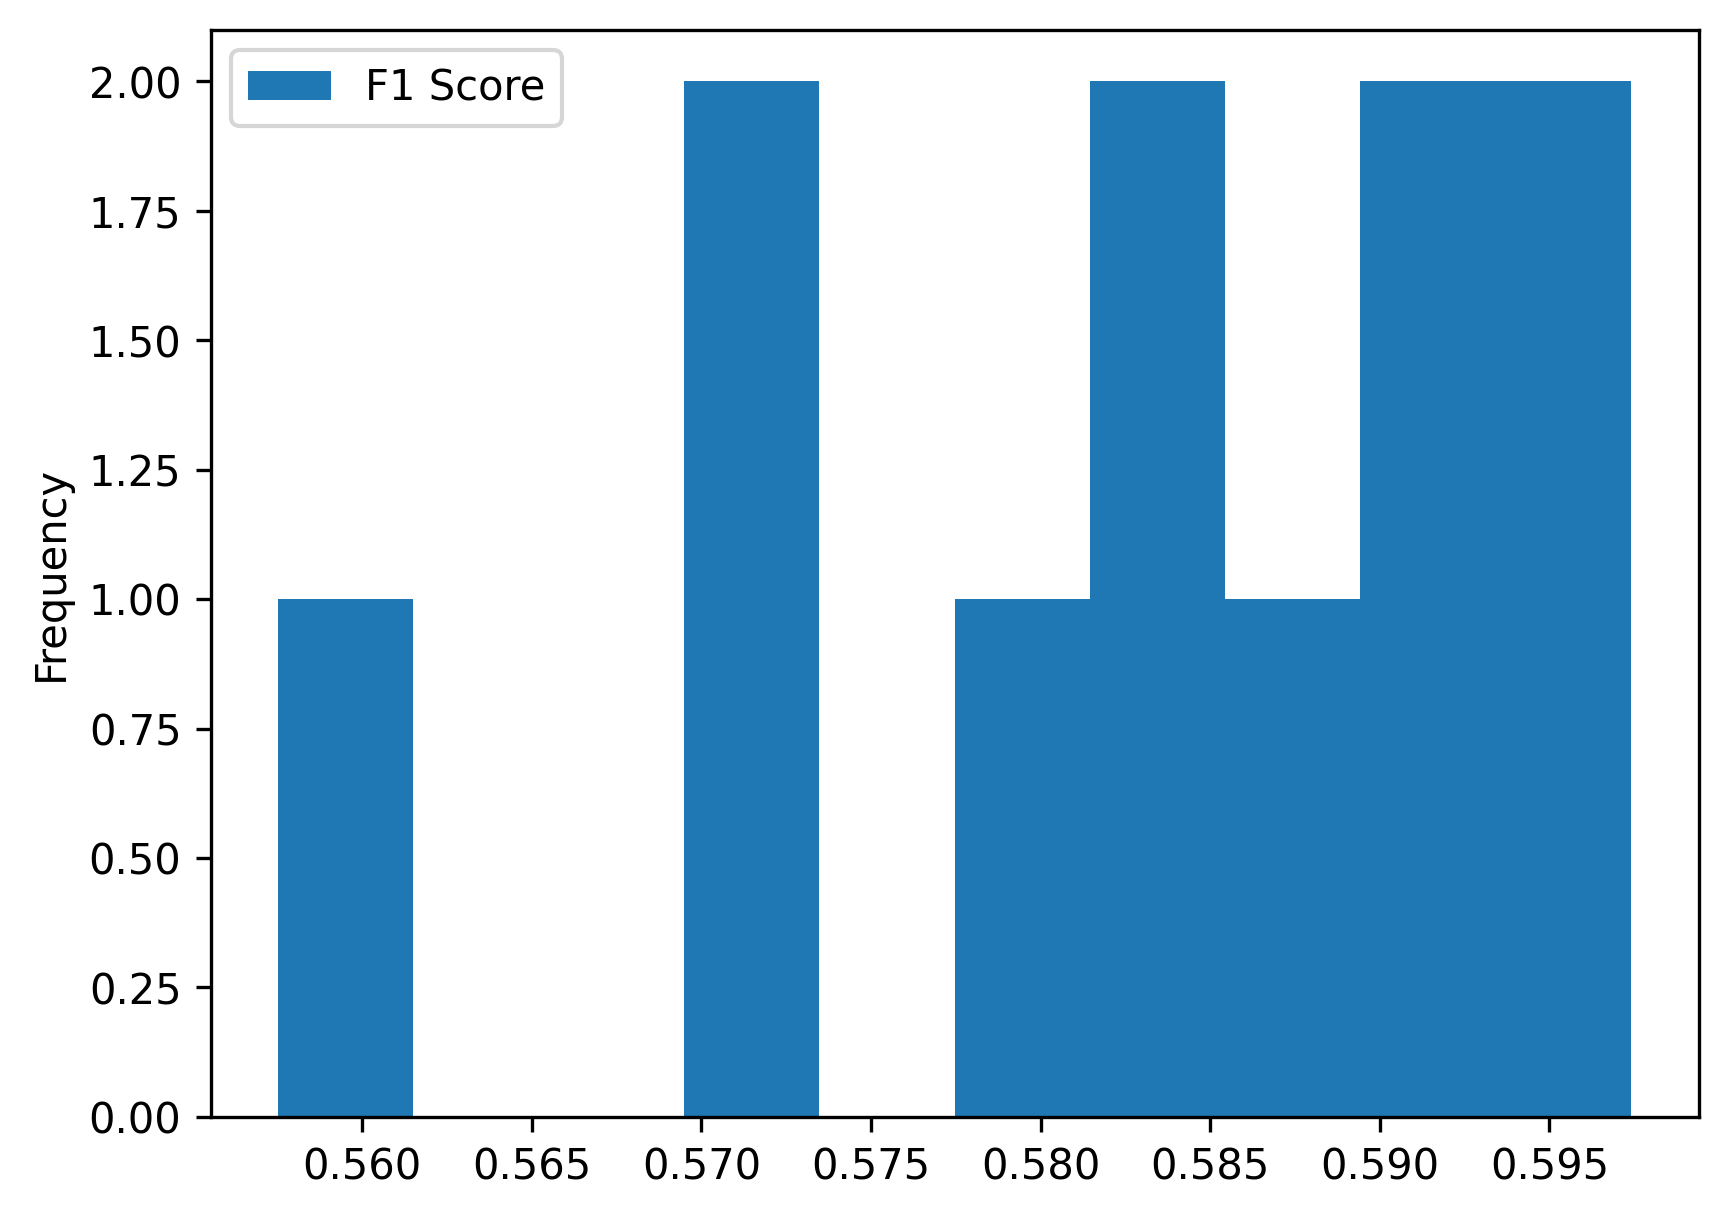

In [ ]:
d = pd.DataFrame()
d["Window Size"] = [str(i) for i in range__]
d["F1 Score"] = f1_scores
d.plot(x="Window Size", y="F1 Score", kind="hist") 

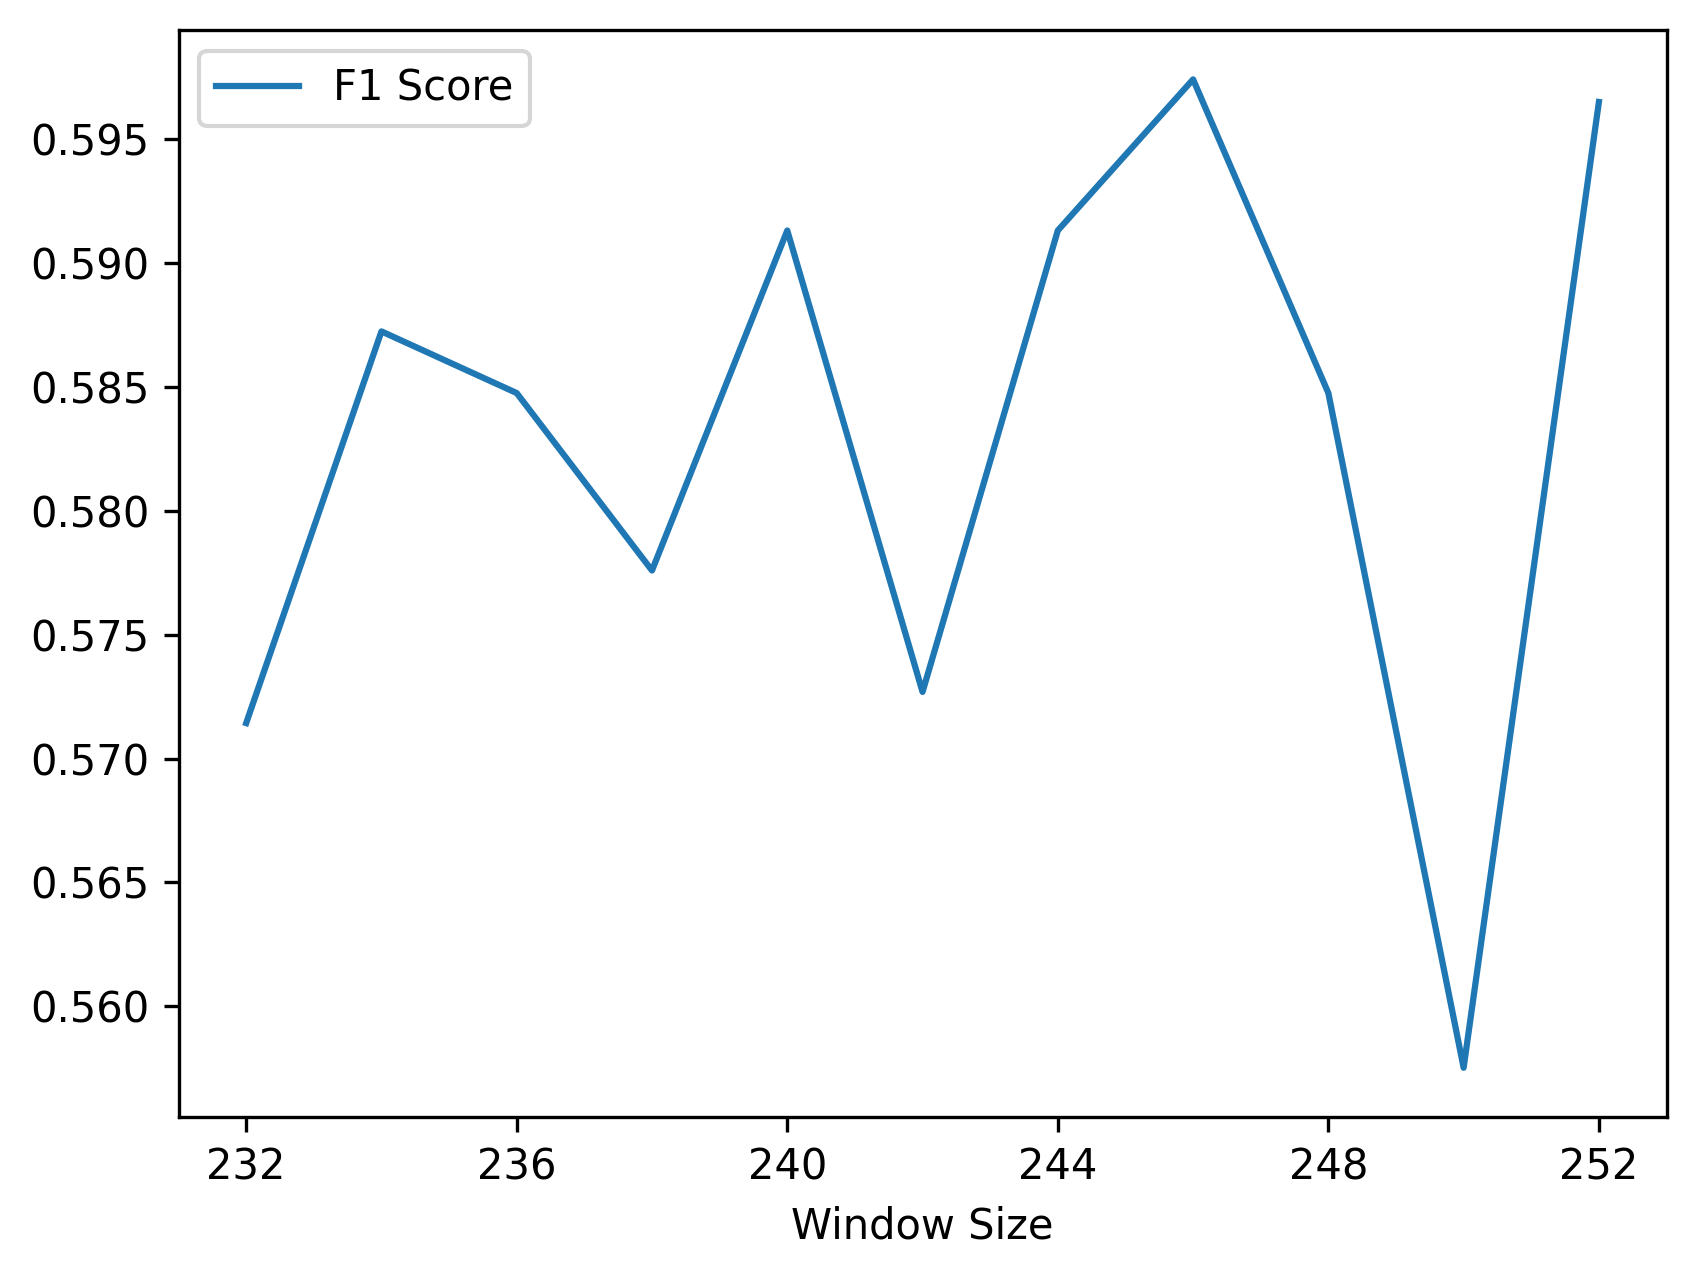

In [ ]:
d.plot(x="Window Size", y="F1 Score", kind="line") 

## Confusion Matrix

In [ ]:
_y = _y[264:]
preds = preds[-218:]
print( confusion_matrix(_y, preds) )
print( "Accuracy Score:", accuracy_score(_y, preds) )
print( "Precision。Score:", precision_score(_y, preds) )
print( "Recall Score:", recall_score(_y, preds) )
print( "F1 Score:", f1_score(_y, preds) )

[[64 42]
 [47 65]]
Accuracy Score: 0.591743119266055
Precision。Score: 0.6074766355140186
Recall Score: 0.5803571428571429
F1 Score: 0.5936073059360729
